In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
# đường dẫn
input_folder_path = "images/input_all"
output_folder_path = "images/output_all"
detect_classes_path = "signs.names.txt"
classify_classes_path = "signs_classes.txt"
yolo_weight_path = 'models/yolov3_training_last.weights'
yolo_conf_path = 'models/yolov3_training.cfg'
cnn_weight_path = 'models/traffic.h5'

# size ảnh
HEIGHT = 32
WIDTH = 32

In [5]:
def random_5_images_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    # đọc ngẫu nhiên 5 ảnh
    for filename in random.sample(filenames,5):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images


def process_img(crop_img):
    plt.figure(figsize=(20,8))

    # show ảnh gốc
    plt.subplot(1,7,1)
    plt.imshow(cv2.cvtColor(crop_img.astype(np.uint8), cv2.COLOR_RGB2BGR))
    plt.title('Ảnh biển báo')


    # kiểm tra độ tương phản
    gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)                    
    contrast_range = np.ptp(gray)  
    if contrast_range < 80:  # tương phản kém
        # tăng tương phản bằng clahe
        lab_image = cv2.cvtColor(crop_img, cv2.COLOR_BGR2LAB)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3, 3))
        lab_image[:, :, 0] = clahe.apply(lab_image[:, :, 0])
        contrast_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2BGR)
    else:
        contrast_image = crop_img

    plt.subplot(1,7,2)
    plt.imshow(cv2.cvtColor(contrast_image.astype(np.uint8), cv2.COLOR_RGB2BGR))
    plt.title('Sau chỉnh sáng')
    

    # Khử nhiễu
    denoised_image = cv2.bilateralFilter(contrast_image, d=9, sigmaColor=75, sigmaSpace=75)

    plt.subplot(1,7,3)
    plt.imshow(cv2.cvtColor(denoised_image.astype(np.uint8), cv2.COLOR_RGB2BGR))
    plt.title('Sau giảm nhiễu')


    # làm nét
    blurred = cv2.GaussianBlur(denoised_image, (0, 0), 3)
    sharp = cv2.addWeighted(denoised_image, 1.5, blurred, -0.5, 0)
    
    plt.subplot(1,7,4)
    plt.imshow(cv2.cvtColor(sharp.astype(np.uint8), cv2.COLOR_RGB2BGR))
    plt.title('Sau làm nét')


    # resize xuống 32x32
    if sharp.shape[0] < 32 * 2 and sharp.shape[1] < 32 * 2:
        resized_image = cv2.resize(sharp, (WIDTH, HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    else:
        blurred_image = cv2.GaussianBlur(sharp, (5, 5), 0)
        resized_image = cv2.resize(blurred_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)

    plt.subplot(1,7,5)
    plt.imshow(cv2.cvtColor(resized_image.astype(np.uint8), cv2.COLOR_RGB2BGR))
    plt.title('Sau resize')


    # giảm nhiễu 2
    resized_image = cv2.bilateralFilter(resized_image, d=5, sigmaColor=50, sigmaSpace=50)


    # show ảnh đã xử lý
    plt.subplot(1,7,6)
    plt.imshow(cv2.cvtColor(resized_image.astype(np.uint8), cv2.COLOR_RGB2BGR))
    plt.title('Sau giảm nhiễu lần 2')
    plt.show()

    return resized_image.reshape(-1, WIDTH,HEIGHT,3)
    

In [14]:
all_images = random_5_images_from_folder(input_folder_path)
print('Total Images: ',len(all_images))

net = cv2.dnn.readNet(yolo_weight_path, yolo_conf_path)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

classes = []
with open(detect_classes_path, "r") as f:
    classes = [line.strip() for line in f.readlines()]

confidence_threshold = 0.5
font = cv2.FONT_HERSHEY_SIMPLEX

classification_model = load_model(cnn_weight_path) 
classes_classification = []

Total Images:  5


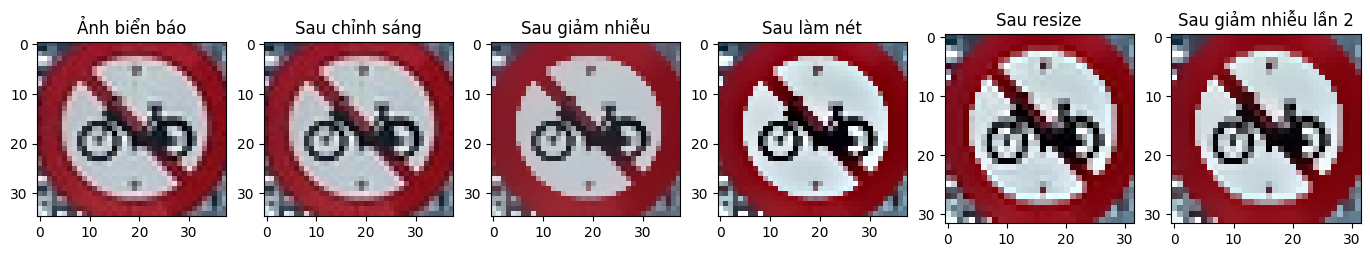

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Sign name: Gioi han toc do (30km/h)


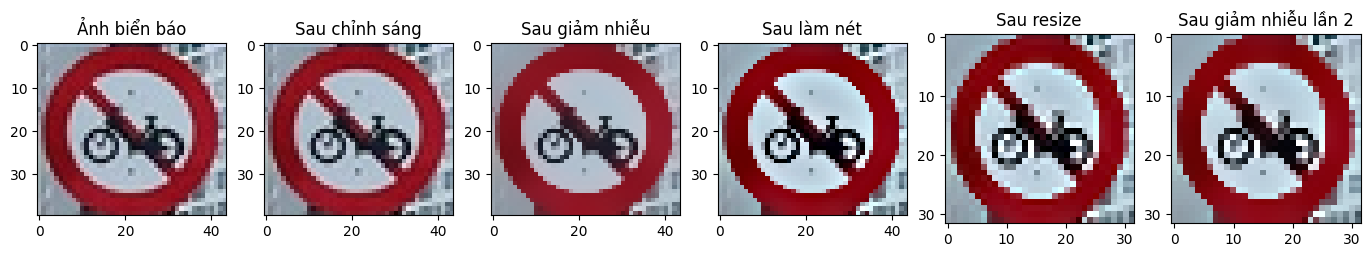

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sign name: Vong xuyen bat buoc


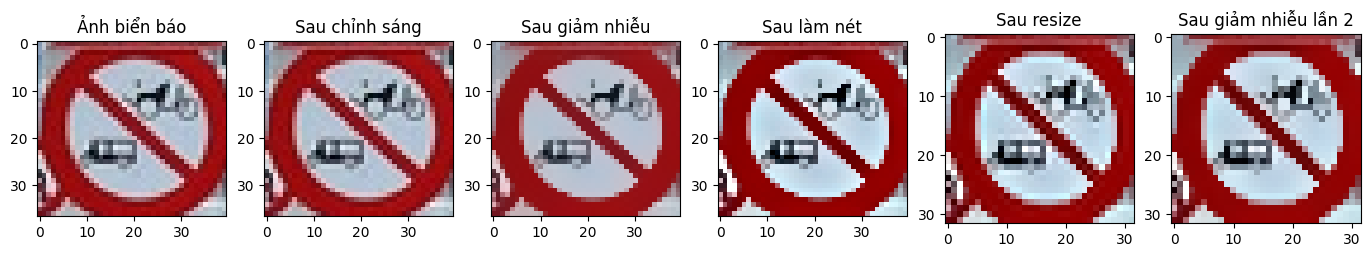

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sign name: Gioi han toc do (30km/h)


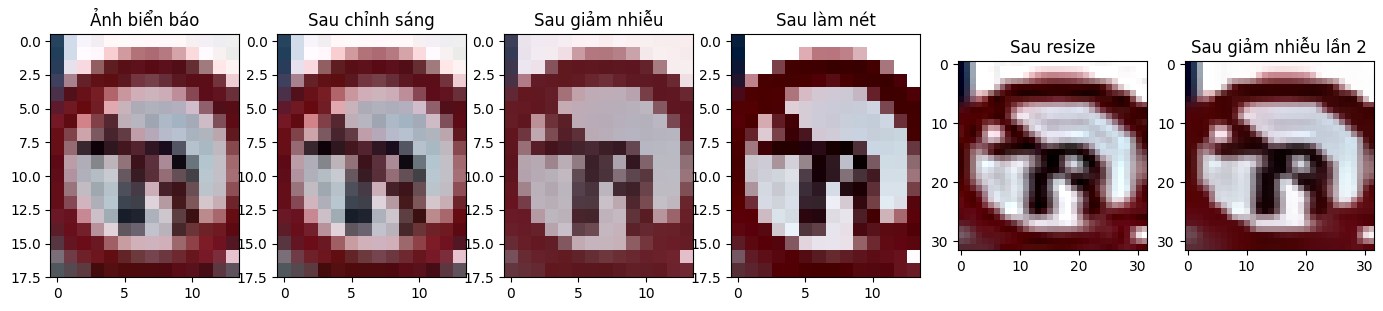

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sign name: Giao nhau voi duong uu tien


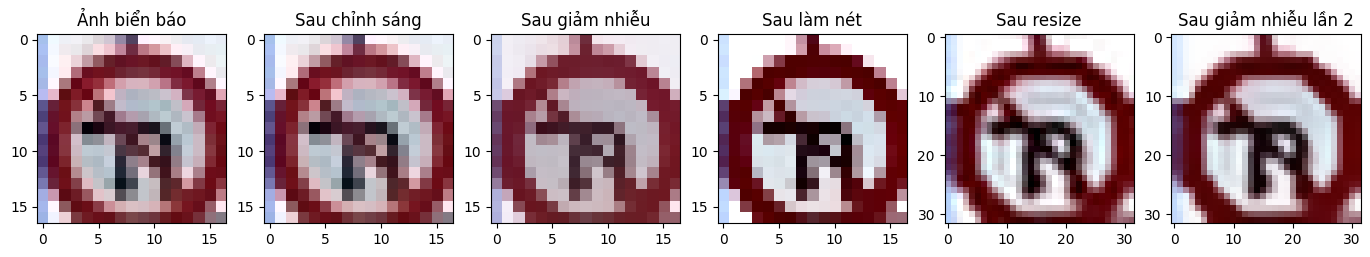

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sign name: Gioi han toc do (50km/h)


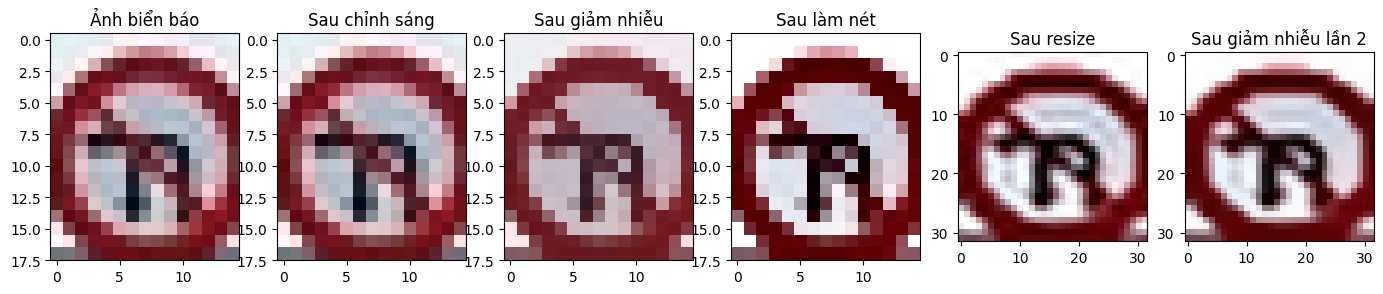

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sign name: Gioi han toc do (50km/h)


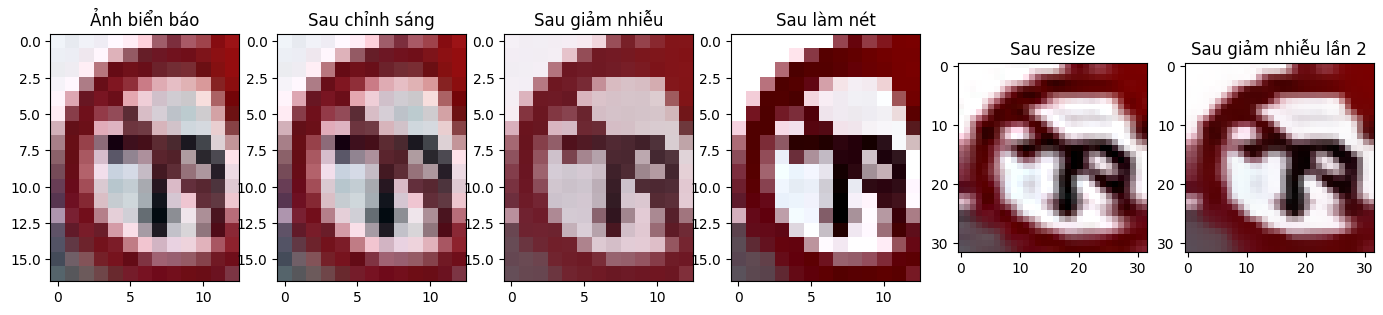

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sign name: Cam vuot cho xe tren 3.5T


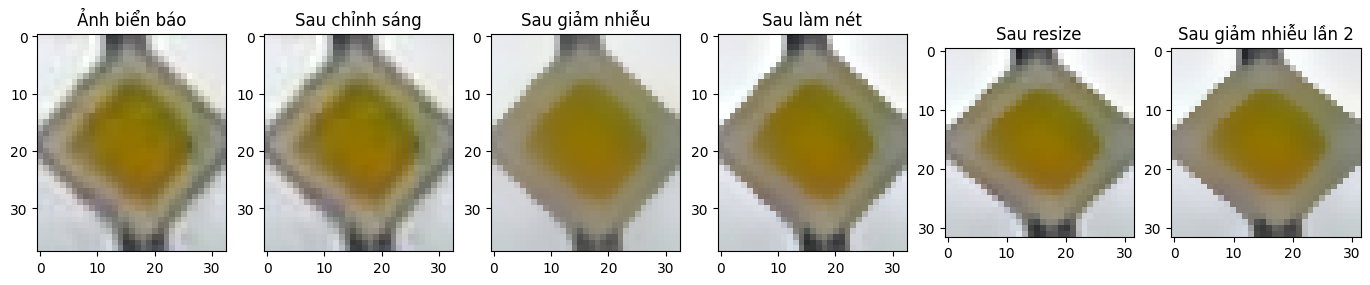

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sign name: Vong xuyen bat buoc


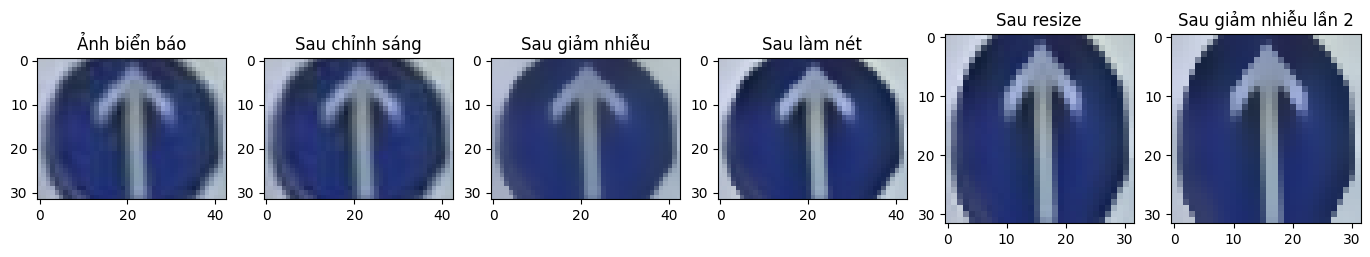

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Sign name: Duong giao nhau


In [15]:
with open(classify_classes_path, "r", encoding='utf-8') as f:
    classes_classification = [line.strip() for line in f.readlines()]

    for j in range(len(all_images)):
        img = all_images[j]
        height, width, channels = img.shape

        # phát hiện biển báo
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        # Showing informations on the screen (YOLO)
        class_ids = []
        confidences = []
        boxes = []
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > confidence_threshold:
                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
        # ảnh để vẽ bounding box
        img_box = img.copy()
        
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                if x<0: 
                    x = 0
                if y<0: 
                    y = 0
                if w<0:
                    w = 0
                if h<0:
                    h = 0

                label = str(classes[class_ids[i]]) + "=" + str(round(confidences[i]*100, 2)) + "%"
                crop_img = img[y:y+h, x:x+w]

                # vẽ bounding box
                img_box = cv2.rectangle(img_box, (x, y), (x + w, y + h), (0,255,0), 2)

                if len(crop_img) > 0:
                    # xử lý ảnh                       
                    edited_image = process_img(crop_img)              

                    # phân loại
                    prediction = np.argmax(classification_model.predict(edited_image))
                    label = str(classes_classification[prediction])
                    img_box = cv2.putText(img_box, label, (x, y), font, 0.5, (0,0,255), 2)
                    print('Sign name:',label)

        # output_path = str(output_folder_path)+ '/' + 'result' + str(j) + '.jpg'
        # cv2.imwrite(output_path, img_box)
